In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import scipy.stats as stats
from sklearn.metrics import roc_auc_score,auc,roc_curve

In [12]:
#Import dữ liệu đã được tiền xử lí
df = pd.read_csv('../../../BankChurners_Preprocessing.csv')

## Chọn Attrition_Flag làm thuộc tính quyết định. Nhưng vì Attrition_Flag đang bị mất cân bằng dữ liệu. Vậy nên ta cần xử lí mất cân bằng trước

Tách dữ liệu thành 2 phần. 1 phần chứa các cột còn lại và cột chứa thuộc tính quyết định.
features: Chứa các thuộc tính còn lại.
labels: Chứa thuộc tính quyết định.

In [13]:
features=df.drop('Attrition_Flag',axis=1)
labels=df['Attrition_Flag']

Chuyển đổi các cột không phải dạng số trong biến features về dạng one-hot vector

In [14]:
features_onehot=pd.get_dummies(features,columns=features.select_dtypes(exclude=['int64']).columns)
features_onehot

,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,...,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Credit_Limit_1.0,Credit_Limit_2.0,Credit_Limit_3.0,Credit_Limit_4.0,Credit_Limit_5.0,Credit_Limit_6.0,Credit_Limit_7.0,Credit_Limit_8.0
0,1,3,3,5,1,3,2,4,5,1,...,5,1,False,False,False,False,False,True,False,False
1,0,5,3,6,1,2,2,4,5,1,...,5,1,False,False,False,False,True,False,False,False
2,1,3,2,4,1,0,1,3,5,1,...,5,0,False,False,True,False,False,False,False,False
3,0,4,1,3,4,1,5,1,5,1,...,5,4,False,False,True,False,False,False,False,False
4,1,3,1,5,1,0,1,3,5,1,...,5,0,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,1,2,3,3,2,3,4,2,4,5,...,5,2,False,False,False,True,False,False,False,False
10123,1,2,1,4,2,3,5,2,5,5,...,2,3,False,False,False,True,False,False,False,False
10124,0,1,2,5,3,4,1,3,5,5,...,5,0,False,False,False,True,False,False,False,False
10125,1,2,2,4,3,3,1,3,1,5,...,4,0,False,False,False,True,False,False,False,False


In [15]:
#Chia tập dữ liệu theo train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split(features_onehot, labels, test_size=0.2, random_state=42,shuffle=True)

In [16]:
# Áp dụng kỹ thuật Oversampling để làm cân bằng dữ liệu
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [17]:
print(y_train_resampled.shape)
print(X_train_resampled.shape)

(13602,)
(13602, 21)


In [18]:
clf = DecisionTreeClassifier(random_state=0)

In [19]:
params= {
    'max_depth': [int(x) for x in np.arange(start = 10, stop = 101, step = 10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto','sqrt','log2']
    }

In [20]:
clf_rd = RandomizedSearchCV(estimator=clf,
                    param_distributions = params,
                                   n_iter = 25,              
                                   refit = "recall",
                                   return_train_score = False,
                                   random_state = 0,
                                   cv = 3,
                                   n_jobs = -1)

In [21]:
clf_rd.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=0, refit='recall')

In [22]:
clf_rd.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 20}

In [23]:
clf=DecisionTreeClassifier(criterion='entropy',
                           max_depth=20, 
                           min_samples_leaf=1,
                           min_samples_split=2,
                           max_features='log2')
clf.fit(X_train_resampled,y_train_resampled)

DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features='log2')

In [24]:
tree_pred = clf.predict(X_test)
tree_score=metrics.accuracy_score(y_test,tree_pred)
print("Accuracy:",tree_score)
print("Report:",metrics.classification_report(y_test,tree_pred))

Accuracy: 0.8983218163869694
Report:               precision    recall  f1-score   support

           0       0.71      0.64      0.67       327
           1       0.93      0.95      0.94      1699

    accuracy                           0.90      2026
   macro avg       0.82      0.79      0.80      2026
weighted avg       0.89      0.90      0.90      2026



In [25]:
tree_cm=metrics.confusion_matrix(y_test,tree_pred)

Text(0.5, 1.0, 'ID3 Accuracy Score : 0.8983218163869694')

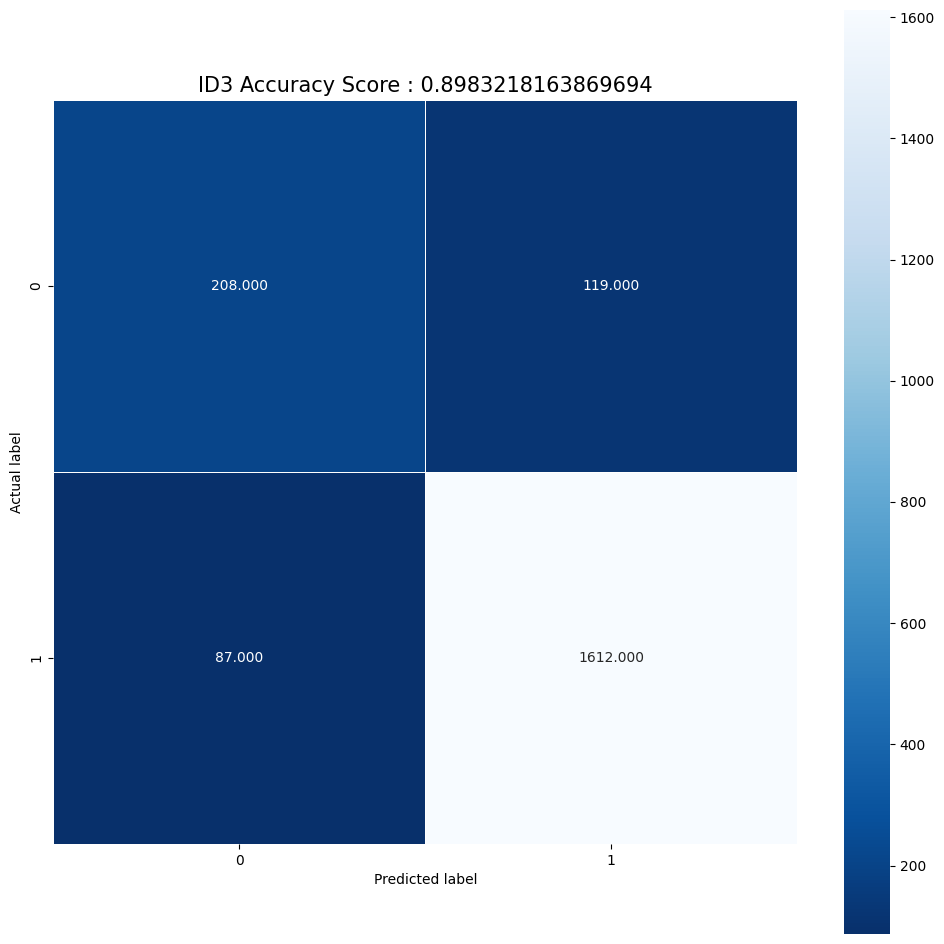

In [26]:
plt.figure(figsize=(12,12))
sns.heatmap(tree_cm,annot=True,fmt=".3f",linewidths=.5,square=True,cmap="Blues_r")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'ID3 Accuracy Score : {0}'.format(tree_score)
plt.title(title,size=15)

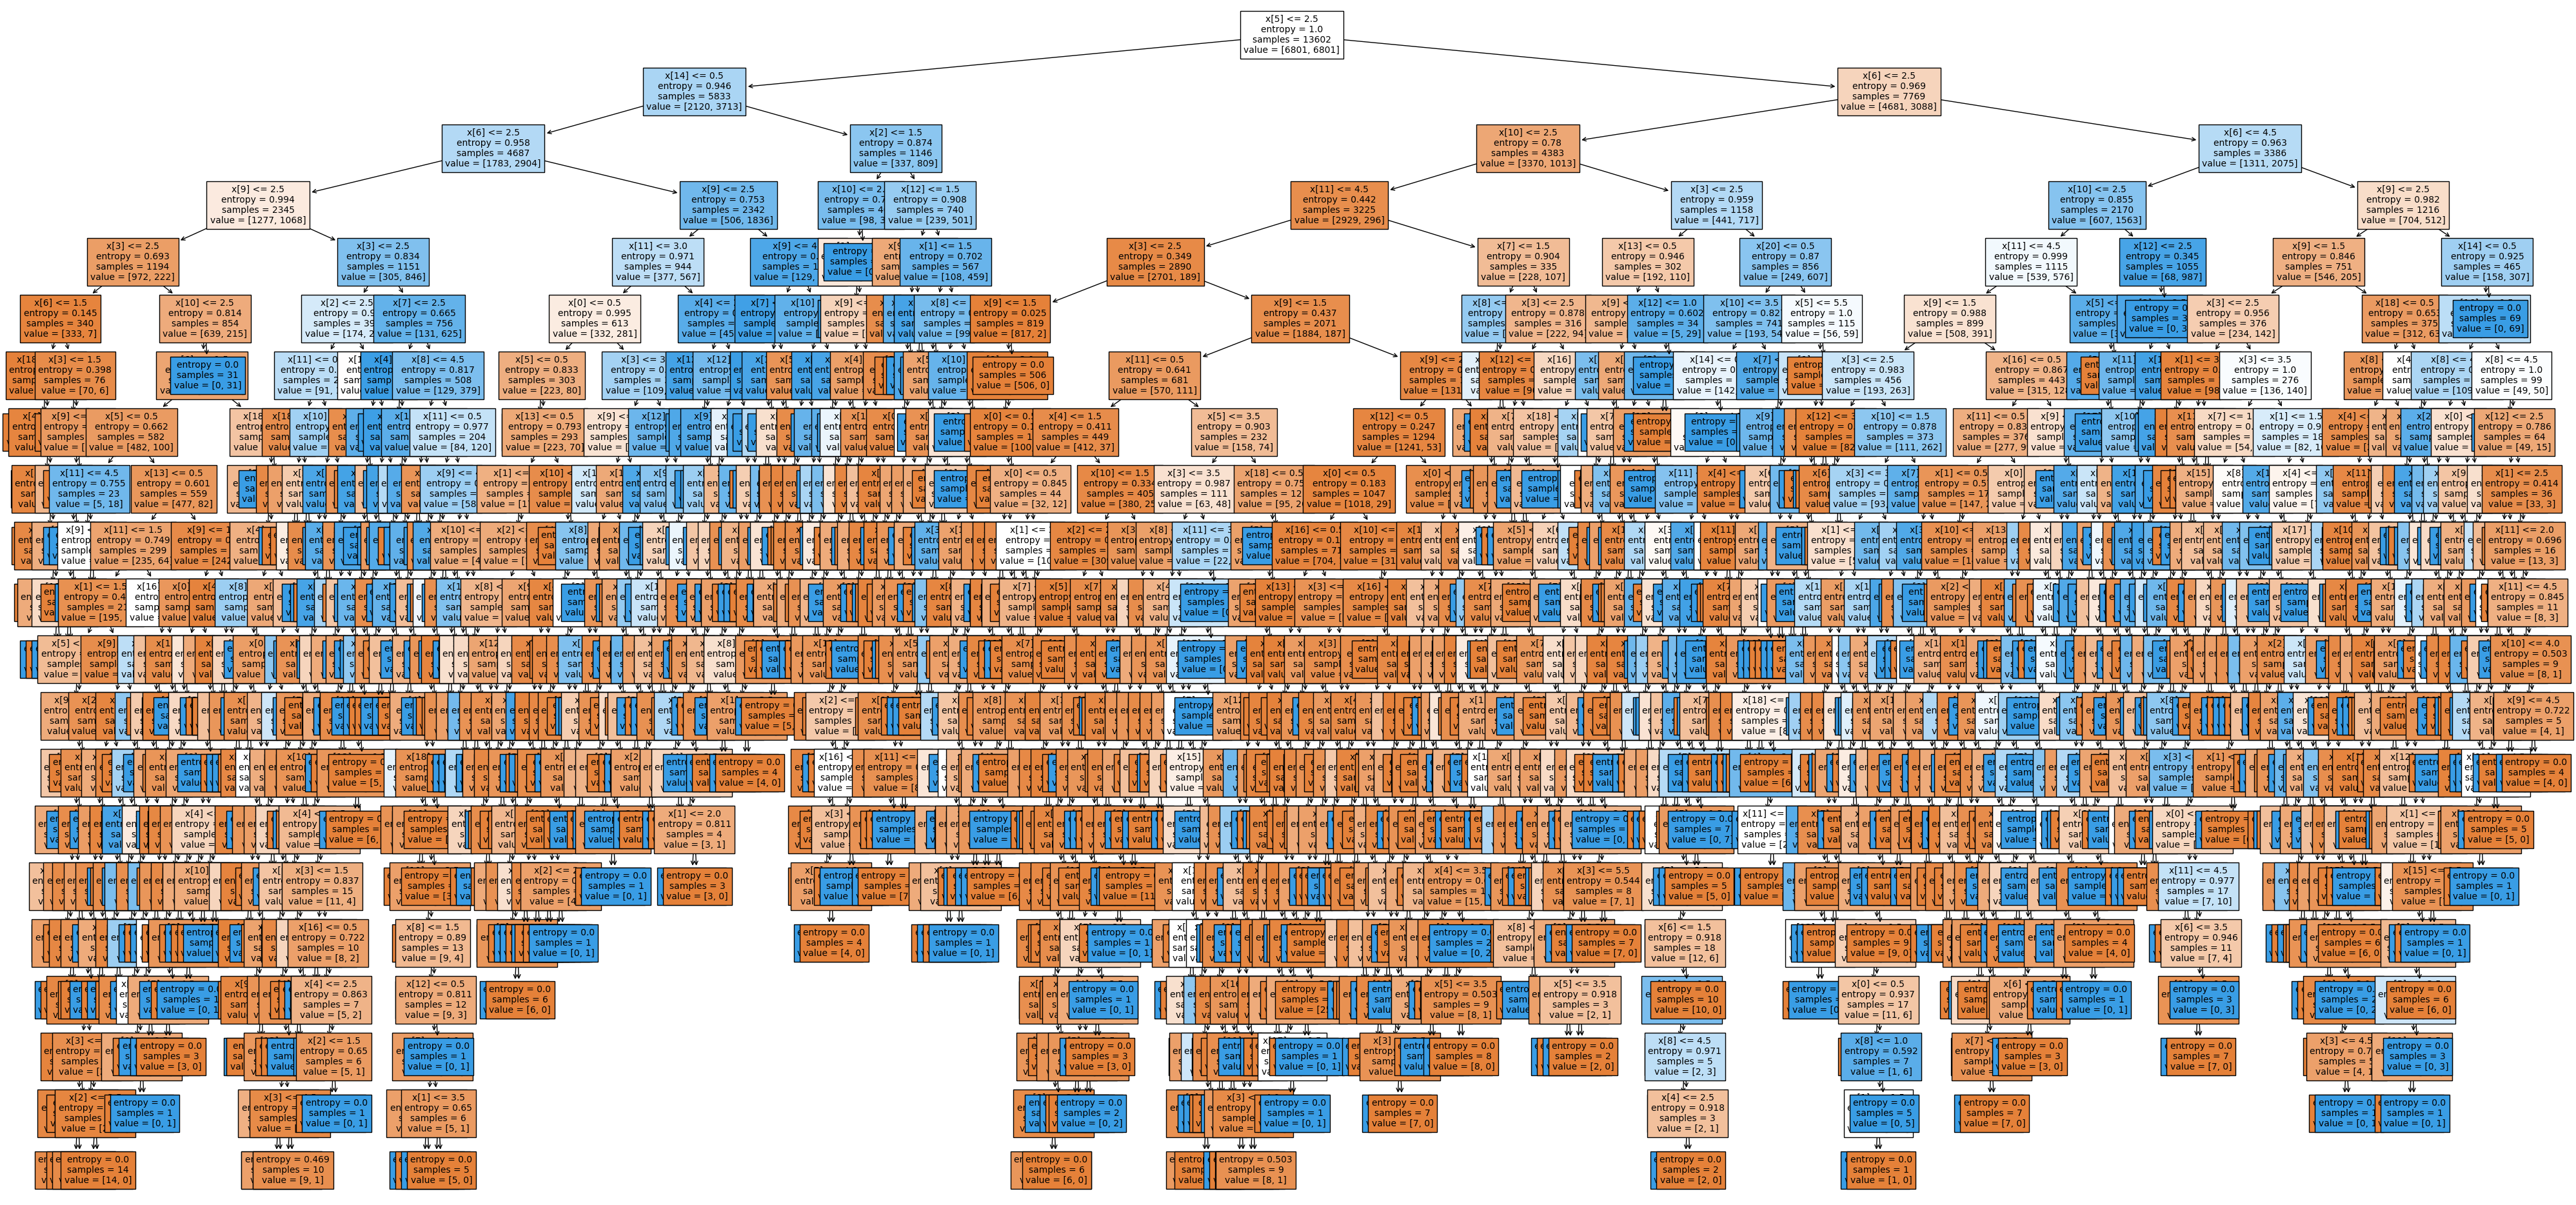

In [27]:
fig,ax=plt.subplots(figsize=(50,24))
tree.plot_tree(clf,filled=True,fontsize=10)
plt.savefig('decision tree',dpi=100)
plt.show()

## TÍNH ROC AUC

In [28]:
y_true=y_test
y_probas = clf.predict_proba(X_test)[:,1]

In [29]:
# Tính đường cong ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
roc_auc = auc(fpr, tpr)

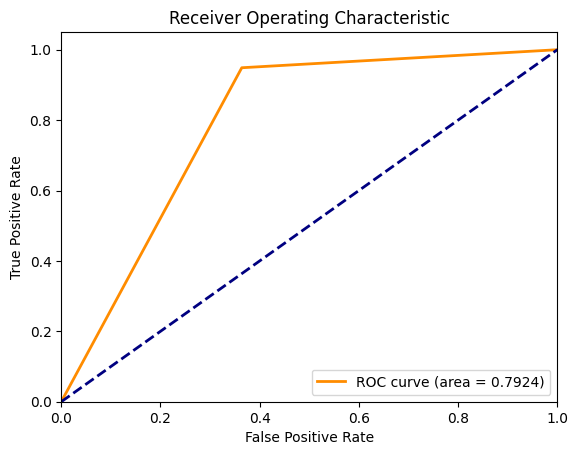

In [30]:
# Vẽ đường cong ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()